# Consumption-Savings with Cash-in-Advance constraint

In [1]:
import tensorflow as tf
import numpy as np
from math import sqrt
from matplotlib import pyplot as plt
from tqdm import tqdm as tqdm         # tqdm is a nice library to visualize ongoing loops
import datetime
# followint lines are used for indicative typing
from typing import Tuple
class Vector: pass

2023-01-25 22:36:04.900897: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


2023-01-25 22:36:20.221524: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Text(0.5, 1.0, 'test')

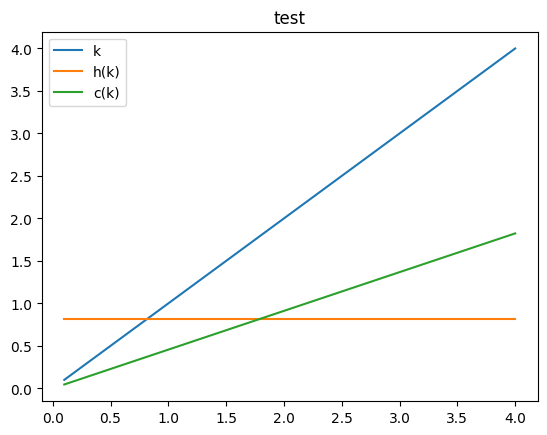

In [2]:
# Model parameters
r = 1.04
γ = 2.0
β = 0.9 
σ = 0.0001
wmin=0.1
wmax=4.0
min_FB = lambda a,b: a+b-tf.sqrt(a**2+b**2)
layers = [
    tf.keras.layers.Dense(32, activation='relu', input_dim=2, bias_initializer='he_uniform'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(2, activation=tf.keras.activations.linear)
]
perceptron = tf.keras.Sequential(layers)

def model(y:Vector,w:Vector)->Tuple[Vector,Vector]:
    y = y/σ/2.0
    w = (w-wmin)/(wmax-wmin)*2.0-1.0
    s = tf.concat([i[:,None] for i in [y,w]],axis=1)
    x = perceptron(s)
    sh = tf.sigmoid(x[:,0])
    h = tf.exp(x[:,1])
    return (sh,h)

wvec = np.linspace(wmin,wmax,100,dtype='float32')
shvec, hvec = model(wvec*0,wvec*0)

plt.plot(wvec, wvec, label = 'k')
plt.plot(wvec, hvec, label='h(k)')
plt.plot(wvec, shvec*wvec, label = 'c(k)')
plt.legend()
plt.title('test')

In [3]:
def residuals(e:Vector,y:Vector,w:Vector):
    n = tf.size(y)
    sh,h=model(y,w)
    c=sh*w
    yp=e
    wp=tf.exp(yp)+(w-c)*r
    shp,hp=model(yp,wp)
    cp = shp*wp
    R1 = β*(cp/c)**(-γ)*r-h
    R2 = min_FB(1-h,1-sh)
    return (R1,R2)

residuals(wvec,wvec,wvec)

(<tf.Tensor: shape=(100,), dtype=float32, numpy=
 array([0.00596525, 0.01008524, 0.01457082,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,

In [4]:
def J(n):
    y = tf.random.normal(shape=(n,),stddev=σ)
    w = tf.random.uniform(shape=(n,),minval=wmin,maxval=wmax)
    e1 = tf.random.normal(shape=(n,),stddev=σ)
    e2 = tf.random.normal(shape=(n,),stddev=σ)
    R1_e1, R2_e1 = residuals(e1, y, w)
    R1_e2, R2_e2 = residuals(e2, y, w)
    R_squared = R1_e1*R1_e2+R2_e1*R2_e2
    return tf.reduce_mean(R_squared)

In [5]:
n = 128
v = J(100)
v.numpy()

0.19693172

In [6]:
θ = perceptron.trainable_variables
print(str(θ)[:1000])

[<tf.Variable 'dense/kernel:0' shape=(2, 32) dtype=float32, numpy=
array([[-0.25755072, -0.38849288,  0.08605501,  0.20149782,  0.40809378,
         0.00573361, -0.18568352, -0.41277745, -0.28822076, -0.1262826 ,
         0.25257328, -0.0276958 , -0.21573217, -0.0133017 ,  0.39219615,
        -0.19901316, -0.01372916, -0.33530992, -0.33659112,  0.16483685,
         0.09874204, -0.15876293,  0.28232178, -0.00793123,  0.34337708,
         0.00471514,  0.34095028,  0.3789386 , -0.04662684,  0.1317006 ,
         0.27976242, -0.35112843],
       [-0.09345961,  0.4033691 , -0.07894352, -0.2117688 , -0.25404847,
        -0.01943144,  0.25786474,  0.27997842,  0.3953139 , -0.36417162,
         0.16391763, -0.11313382, -0.31174746,  0.11314693,  0.11531159,
        -0.31372696,  0.19272098, -0.36741036, -0.39099446,  0.14960608,
        -0.35642707, -0.17639796, -0.41438836, -0.3728314 , -0.3984094 ,
        -0.24374135,  0.04821974,  0.22768816,  0.137858  , -0.29809132,
         0.03686637, -

In [7]:
from tensorflow.keras.optimizers import Adam, SGD
variables = perceptron.trainable_variables
optimizer = Adam()

In [8]:
@tf.function
def training_step():
    
    with tf.GradientTape() as tape:
        xx = J(n)
        
    grads = tape.gradient(xx,θ)
    optimizer.apply_gradients(zip(grads,θ))
    
    return xx

def train_me(K):
    vals=[]
    for k in tqdm(tf.range(K)):
        val=training_step()
        vals.append(val.numpy())
    return vals

results = train_me(5000)

  0%|                                                  | 0/5000 [00:00<?, ?it/s]

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


100%|██████████████████████████████████████| 5000/5000 [00:10<00:00, 458.07it/s]


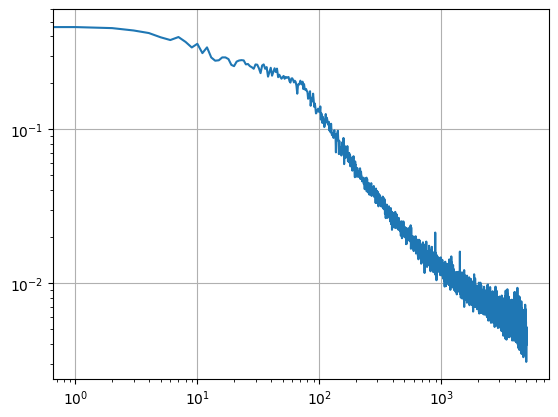

In [9]:
plt.plot(np.sqrt(results))
plt.xscale('log')
plt.yscale('log')
plt.grid()

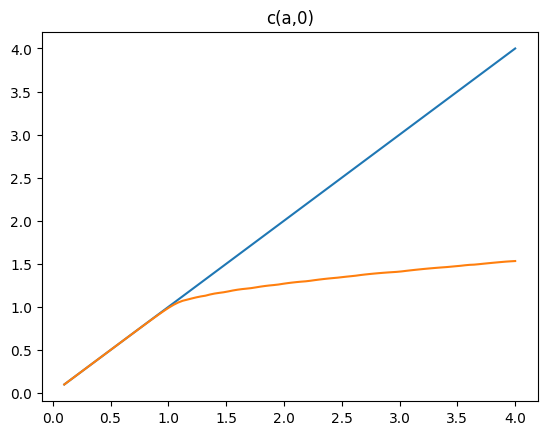

In [10]:
wvec = np.linspace(wmin,wmax,100,dtype='float32')
shvec,hvec = model(wvec*0,wvec)
plt.title('c(a,0)')
plt.plot(wvec,wvec)
plt.plot(wvec,shvec*wvec)
plt.show()